In [61]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd

In [62]:
pretrained_model = "checkpoint_model.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [63]:
# LeNet Model 定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=5) #畳み込み層nn.Conv2d(入力のチャネル数, 出力のチャネル数，カーネルの1辺のサイズ)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d() #過学習を防ぐためにいくつかのノードを無効にする
        # self.fc1 = nn.Linear(320, 50) #全結合層nn.Linear(入力のサイズ(20channel×4height×4width), 出力サイズ) height, weightについては計算して事前に出す
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        # x = F.relu(F.max_pool2d(self.conv1(x), 2)) #活性化関数Relu, Maxプーリング
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(-1, 320) #サイズを調整x.view(-1, 指定するサイズ)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # return F.log_softmax(x, dim=1)

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])), 
        batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [64]:
def im_is_black(image):
    if image < torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [65]:
def im_is_white(image):
    if image >= torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [66]:
def character_search(image):
    image_copy = copy.deepcopy(image)
    for x in range(28):
        for y in range(28):
            if im_is_black(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 28) and (y + j != -1) and (y + j != 28):
                            if im_is_white(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
            elif im_is_white(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 28) and (y + j != -1) and (y + j != 28):
                            if im_is_black(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
    image_chain = list(itertools.chain.from_iterable(image_copy))
    return image_chain

In [67]:
def fgabsm_attack1(image, data_grad):
    count = 0
    for i in list(itertools.chain.from_iterable(image.data[0][0])):
        if i > torch.Tensor([0]).to("cuda"):
            count += 1

    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    threshold = heapq.nlargest(int(count * 0.25), list(map(abs, data_grad_chain)))[int(count * 0.25) - 1]
    attack = (data_grad >= threshold).float() * 2 - (data_grad <= -threshold).float() * 2

    # image_copy = copy.deepcopy(image).data[0][0]
    # character_coordinate = character_search(image_copy)
    # for j in range(784):
    #     if character_coordinate[j] == torch.Tensor([0]).to("cuda"):
    #         attack[0][0][j // 28][j - 28 * (j // 28)] = torch.Tensor([0]).to("cuda")
            
    perturbed_image = image + attack
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [68]:
def fgabsm_attack2(image, data_grad):
    count = 0
    for i in list(itertools.chain.from_iterable(image.data[0][0])):
        if i > torch.Tensor([0]).to("cuda"):
            count += 1

    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    threshold = heapq.nlargest(int(count * 0.25), list(map(abs, data_grad_chain)))[int(count * 0.25) - 1]
    attack = (data_grad >= threshold).float() * 2 - (data_grad <= -threshold).float() * 2
    # a = list(itertools.chain.from_iterable(attack[0][0]))
    # print("before2:{} -2:{}".format(a.count(2), a.count(-2)))

    image_copy = copy.deepcopy(image).data[0][0]
    character_coordinate = character_search(image_copy)
    for j in range(784):
        if character_coordinate[j] == torch.Tensor([0]).to("cuda"):
            attack[0][0][j // 28][j - 28 * (j // 28)] = torch.Tensor([0]).to("cuda")
    
    # a = list(itertools.chain.from_iterable(attack[0][0]))
    # print("after2:{} -2:{}".format(a.count(2), a.count(-2)))
            
    perturbed_image = image + attack
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [69]:
def test( model, device, test_loader):

    # 精度カウンター
    correct1 = 0
    correct2 = 0
    count = 0
    count_list = [0] * 10

    adv_examples = []
    i=0
    dirname_grad = "../org+adv/grad/"
    dirname_org_T = "../org+adv/org_T/"
    dirname_adv1_T = "../org+adv/adv1_T/"
    dirname_adv1_F = "../org+adv/adv1_F/"
    dirname_adv2_T = "../org+adv/adv2_T/"
    dirname_adv2_F = "../org+adv/adv2_F/"
    dirname_adv1F_adv2T = "../org+adv/adv1F_adv2T/"
    dirname_adv1F_adv2F = "../org+adv/adv1F_adv2F/"


    # テスト用データセット内の全てのサンプルをループします
    for data, target in test_loader:
        
        i+=1
        if i==150:
            break
        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.to(device)
        data = (data >= torch.Tensor([0]).to("cuda")).float() - (data < torch.Tensor([0]).to("cuda")).float()

        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        if init_pred.item() != target.item():
            continue

        # 損失を計算します
        loss = F.nll_loss(output, target)

        # 既存の勾配を全てゼロにします
        model.zero_grad()

        # 逆伝播させてモデルの勾配を計算します
        loss.backward()

        # データの勾配を取得します
        print(data)
        data_grad = data.grad.data
        # print(data)

        # FGSMによる攻撃の関数を呼び出します
        perturbed_data1 = fgabsm_attack1(data, data_grad)
        # print(perturbed_data1)
        perturbed_data2 = fgabsm_attack2(data, data_grad)

        # ノイズ付き画像を再度分類します
        output1 = model(perturbed_data1)
        output2 = model(perturbed_data2)

        # 攻撃の成功を確認します
        final_pred1 = output1.max(1, keepdim=True)[1] # log-probabilityが最大のインデックスを取得します
        final_pred2 = output2.max(1, keepdim=True)[1]

        org = data.squeeze().detach().cpu().numpy()
        adv1 = perturbed_data1.squeeze().detach().cpu().numpy()
        adv2 = perturbed_data2.squeeze().detach().cpu().numpy()
        
        count += 1

        for j in [dirname_grad, dirname_org_T, dirname_adv1_T, dirname_adv1_F, dirname_adv2_T, dirname_adv2_F, dirname_adv1F_adv2T, dirname_adv1F_adv2F]:
            for k in ["0/", "1/", "2/", "3/", "4/", "5/", "6/", "7/", "8/", "9/"]:
                os.makedirs(j + k, exist_ok=True)
        
        count_list[init_pred.item()] += 1
        
        #勾配のヒートマップ
        grad_map = data_grad.squeeze().detach().cpu().numpy()
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_grad + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), grad_map, cmap="seismic")
        
        #勾配の絶対値のグラフ
        sns.set()
        sns.set_style('whitegrid')
        sns.set_palette('gray')
        data_grad = data_grad.cpu()
        data_grad = list(list(map(abs, itertools.chain.from_iterable(data_grad[0][0]))))
        data_grad.sort(reverse=True)
        x = np.array(list(range(1, 785)))
        y = np.array(data_grad)
        fig = plt.figure()
        ax = fig.subplots()
        ax.plot(x, y)
        ax.set_xlabel('absolute gradient rank')
        ax.set_ylabel('absolute gradient')
        fig.savefig(dirname_grad + "{}/graph{}.png".format(init_pred.item(), count_list[init_pred.item()]))

        #各条件を満たす画像の保存
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_org_T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), org, cmap="gray")
        

        if final_pred1.item() == target.item():
            correct1 += 1
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv1_T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), adv1, cmap="gray")
        
        if final_pred1.item() != target.item():
            os.makedirs(dirname_adv1_F + "{}/{}→{}/".format(init_pred.item(), init_pred.item(), final_pred1.item()), exist_ok=True)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv1_F + "{}/{}→{}/{}.png".format(init_pred.item(), init_pred.item(), final_pred1.item(), count_list[init_pred.item()]), adv1, cmap="gray")

        if final_pred2.item() == target.item():
            correct2 += 1
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv2_T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), adv2, cmap="gray")

        if final_pred2.item() != target.item():
            os.makedirs(dirname_adv2_F + "{}/{}→{}/".format(init_pred.item(), init_pred.item(), final_pred2.item()), exist_ok=True)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv2_F + "{}/{}→{}/{}.png".format(init_pred.item(), init_pred.item(), final_pred2.item(), count_list[init_pred.item()]), adv2, cmap="gray")

        if final_pred1.item() != target.item() and final_pred2.item() == target.item():
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv1F_adv2T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), adv2, cmap="gray")

        if final_pred1.item() != target.item() and final_pred2.item() != target.item():
            os.makedirs(dirname_adv1F_adv2F + "{}/{}→{}/".format(init_pred.item(), init_pred.item(), final_pred2.item()), exist_ok=True)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv1F_adv2F + "{}/{}→{}/{}.png".format(init_pred.item(), init_pred.item(), final_pred2.item(), count_list[init_pred.item()]), adv2, cmap="gray")

        

        if (final_pred1.item() != target.item()) and (final_pred1.item() == final_pred2.item()):
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 25:
                adv_examples.append( (init_pred.item(), final_pred1.item(), org, adv1, adv2))
                if len(adv_examples) == 25:
                    break


    # epsilonごとの最終的な精度を算出
    final_acc1 = correct1/float(len(test_loader))
    final_acc2 = correct2/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct1, len(test_loader), final_acc1))
    print("Test Accuracy = {} / {} = {}".format(correct2, len(test_loader), final_acc2))

    # 精度と敵対的サンプルを返却
    return final_acc2, adv_examples

tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -

KeyboardInterrupt: 

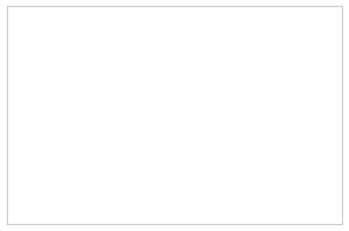

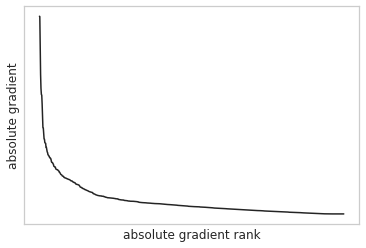

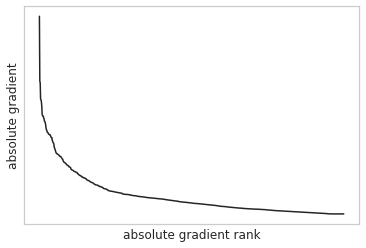

In [70]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
acc, ex = test(model, device, test_loader)
accuracies.append(acc)
examples.append(ex)

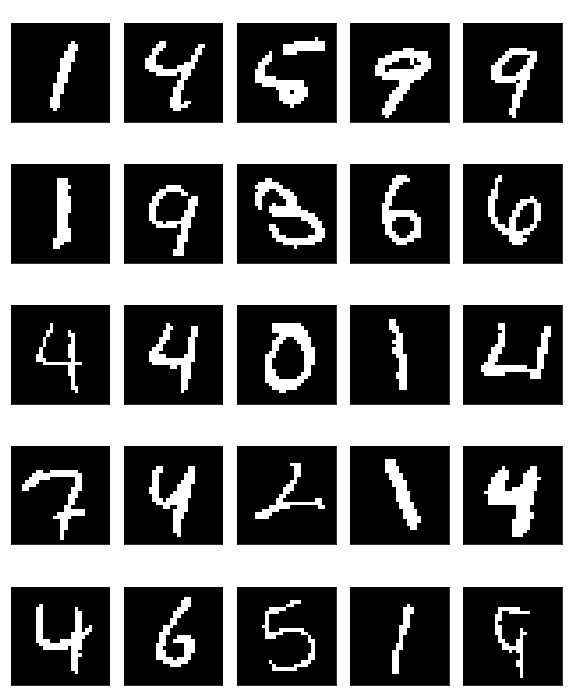

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv, org_ex, adv_ex1,adv_ex2 = examples[0][j]
    plt.title("{}".format(orig), color="white")
    plt.imshow(org_ex, cmap="gray")
plt.tight_layout()
plt.show()

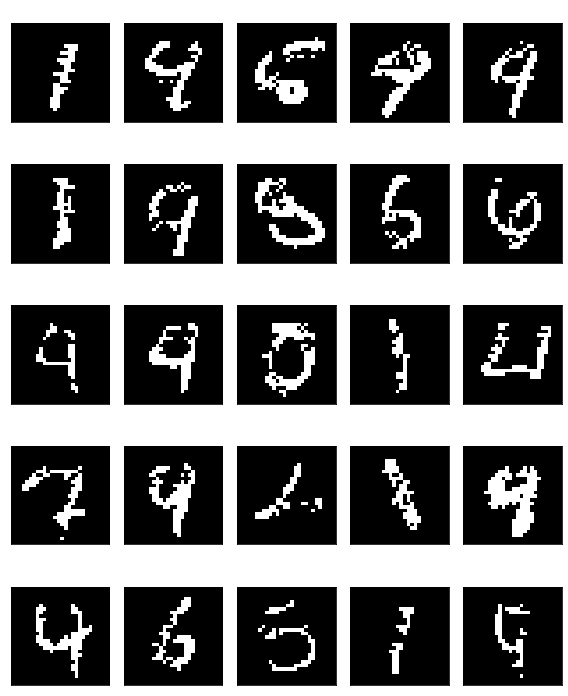

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, org_ex, adv_ex1, adv_ex2 = examples[0][j]
    plt.title("{} -> {}".format(orig, adv), color="white")
    plt.imshow(adv_ex1, cmap="gray")
plt.tight_layout()
plt.show()

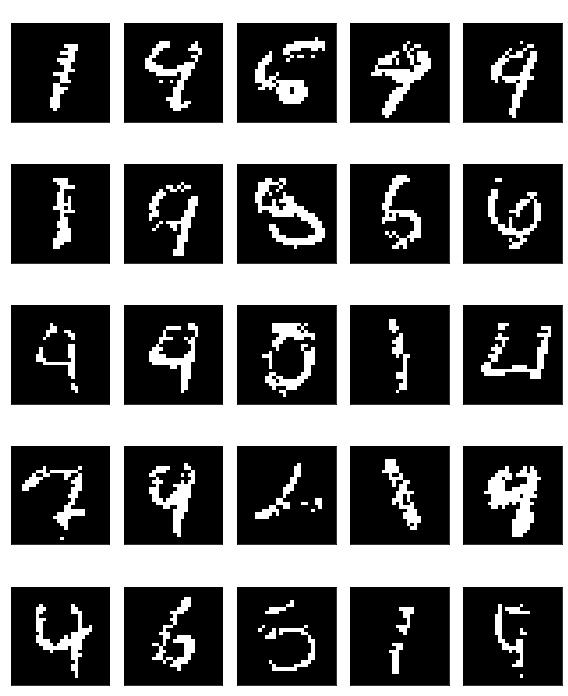

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv,adv_ex1,adv_ex2,ex = examples[0][j]
    plt.title("{}".format(orig, adv), color="white")
    plt.imshow(adv_ex2, cmap="gray")
    # plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()